In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Hindered Rotors, Scan, FakeStatMech, additional functions

In [70]:
from rdkit import Chem
import cclib

from autotst.calculators.gaussian import read_gaussian_out

#from rmgpy.molecule import Molecule as RMG_Molecule

#from autotst.species import Species as TS_Species
from autotst.species import Conformer

import matplotlib.pyplot as plt
import numpy as np

class Hindered_Rotors:
    
    def __init__(self, conformer, label=None, path=None):
        """
        Class for hindered rotor calculation methods
        
        conformer :: autotst.species Conformer object
        path :: General path where files relevant to this conformer can be found or written to
        
        self.scans :: list of Scan instances
        """
        
        
        self.__conformer__ = conformer
        self.SMILES = conformer.smiles

        self.path = path
        
        
        self.AugInChIKey = conformer.rmg_molecule.toAugmentedInChIKey()
        self.label = label
        
        self.__geoIsOpt__ = False
        self.__torsions__ = None

        self.scans = []

        return
    
    def get_Conformer(self):
        return self.__conformer__
    
    def get_GeoIsOpt(self):
        return self.__geoIsOpt__
    
    def get_Torsions(self):
        return self.__torsions__
    
    def update_Conformer(self, filename=None, path=None):
        """
        Updates conformer geometry from Gaussian geometry optimization output. If no filename specified tries by naming convention within path
        
        filename :: Geometry optimization log from Gaussian. Defualt is AugInChIKey + _GeoFreq.log
        path :: path of file, default to cwd
        """
        self.__geoIsOpt__ = False
        self.__torsions__ = None
        
        if filename is None:
            filename = self.label + '_GeoFreq.log'
        
        home = os.getcwd()
        if path is None:
            path = home
            
        os.chdir(path)
        
        self.__conformer__.ase_molecule = read_gaussian_out(filename)
        self.__conformer__.update_coords()
        self.__torsions__ = self.__conformer__.get_torsions()
        self.__geoIsOpt__ = True
        
        os.chdir(home)
        return self.get_GeoIsOpt()
 
    def create_Scan(self, torsion, steps=None, stepsize_deg=None, path=None, label=None):
        """
        Creates Scan object and appends it to self.scans
        
        torsion             :: Torsion object
        steps               :: Number of steps taken during scan (int)
        stepsize_deg        :: DEGREES between steps (float)
        path                :: General path where things like a geometery log, scan input, and scan log can be found
        """
        if steps is not None:
            assert isinstance(steps, int)
        if stepsize_deg is not None:
            assert isinstance(stepsize_deg, float)
        
        if self.get_GeoIsOpt():
            conf = self.get_Conformer()
            scan_inst = Scan(conf, torsion, steps, stepsize_deg, path=path, label=None)
            self.scans.append(scan_inst)
        return
    
    
    def generate_Scans(self, steps=None, stepsize_deg=None, path=None, label=None):
        """
        Generates Scan instance for every torsion
        steps               :: Number of steps taken during scan (int)
        stepsize_deg        :: DEGREES between steps (float)
        path                :: General path where things like geometery logs, scan inputs, and scan logs can be found
        """
        
        if self.get_GeoIsOpt():
            for torsion in self.get_Torsions():
                self.create_Scan(torsion, steps=steps, stepsize_deg=stepsize_deg, path=path, label=label)
        return
    
    def set_ScanData(self):
        if self.get_GeoIsOpt(): 
            for scan in self.scans:
                scan.set_Data()

        return
    
    def check_AllScanSCFEnergies(self):
        scan_mins = {}
        for scan in self.scans:
            scan_mins[scan] = scan.check_scfEnergyMinIdx() 
        return scan_mins

%matplotlib inline
import arkane
import os
from rdkit import Chem








class Scan:
    
    def __init__(self, 
                 conformer, 
                 torsion, 
                 steps=None, 
                 stepsize_deg=None, 
                 path=None, 
                 label=None, 
                 geo_log=None, 
                 tor_com=None, 
                 tor_log=None):
        """
        Scan Class
        
        conformer       :: autotst conformer object
        torsion         :: autotst torsion object
        steps           :: Number of steps taken during scan (int)
        stepsize_deg    :: DEGREES between steps (float)
        path            :: General path where things like geometery logs, scan inputs, and scan logs can be found
        
        geo_log         :: Name of gaussian geometry optimization log that the scan is based off of
        tor_com         :: Name of gaussian input for scan
        tor_log         :: Name of gaussian output log for scan
        
        self.i          :: index i for torsion indices: i,j,k,l
        self.j          :: index j for torsion indices: i,j,k,l
        self.k          :: index k for torsion indices: i,j,k,l
        self.l          :: index l for torsion indices: i,j,k,l
        
        self.stepsize_rad    :: Radians between steps (float)
        
        self.data            :: All data read in from cclib
        self.opt_indices     :: Indices relating to fully optimized geometries (at each scan step, multipl optimization take place until a final optimized geometry is found)
        self.opt_SCFEnergies :: SCF Energies of optimized geometries
        self.atomCoords      :: atom coords of all geometries in scan
        
        self.ark_energies    :: Energy of optimized geometry at each theta (different units than from cclib)
        self.ark_thetas      :: Theta at each step
        """
        
        self.__conformer__ = conformer
        self.__torsion__ = torsion
        
        self.AugInChIKey = Chem.rdinchi.InchiToInchiKey(Chem.MolToInchi(
            Chem.MolFromSmiles(self.__conformer__.smiles)))
        
        self.label = label
        
        self.path = path
        
        self.i = torsion.atom_indices[0]
        self.j = torsion.atom_indices[1]
        self.k = torsion.atom_indices[2]
        self.l = torsion.atom_indices[3]
        
        if steps is not None:
            assert isinstance(steps, int)
        if stepsize_deg is not None:
            assert isinstance(stepsize_deg, float)
        
        self.steps = steps
        self.stepsize_deg = stepsize_deg
        
        
        self.geo_log = geo_log
        self.input_com = tor_com
        self.output_log = tor_log
        
        
        #Info from cclib
        self.data = None
        self.opt_indices = None
        self.start_indices = None
        self.opt_SCFEnergies = None
        self.atomCoords = None
        
        #Redundant info from Arkane
        self.ark_energies = None
        
        return
    
    def get_Conformer(self):
        return self.__conformer__
    
    def get_Torsion(self):
        return self.__torsion__
        
    def set_DefaultFiles(self):
        """
        Sets geo_log, input_com, and output_log per naming convention around AugInChIKey
        
        geo_log         :: Name of gaussian geometry optimization log that the scan is based off of
        tor_com         :: Name of gaussian input for scan
        tor_log         :: Name of gaussian output log for scan
        """
        
        self.geo_log = self.AugInChIKey + '_Geo.log'

        a = min([self.j, self.k])
        b = max([self.j, self.k])
        
        self.input_com = self.AugInChIKey + '_tor{}{}'.format(a, b) + '.com'
        self.output_log = self.AugInChIKey + '_tor{}{}'.format(a, b) + '.log'
        return
    
    def write_TorInput(self,
                       filename=None,
                       path=None, 
                       method=None,
                       basis=None,
                       job=None, 
                       steps=None, 
                       stepsize_deg=None):
        """
        Write Gaussian input file for torsion scan
        
        filename :: desired file name to be written to
        path     :: path of file to write
        method   :: Gaussian method
        basis    :: Gaussian basis
        job      :: Gaussian job key word
        
        steps :: Number of steps in scan
        stepsize_deg :: change in DEGREES between steps
        """
        
        if filename is None:
            assert self.input_com is not None
            filename = self.input_com
        
        if path is None:
            path = self.path
        
        if method is None:
            method = 'm062x'
        
        if basis is None:
            basis = '6-311+g(2df,2p)'
        
        if job is None:
            job = 'Opt=(CalcFC,ModRedun)'
            
        if steps is None:
            steps = self.steps
        
        if stepsize_deg is None:
            stepsize_deg = self.stepsize_deg
        
        
        torsion = self.get_Torsion()
        conf = self.get_Conformer()
        mol = conf.rmg_molecule
        
        mol.updateMultiplicity()
        
        output = '%nprocshared=20\n'
        output += '%mem=5GB\n'
        output += '#p {0}/{1} {2}\n'.format(method, basis, job)
        output += '\nGaussian Input Prepared from Scan Object\n'
        output += '\n{} {}\n'.format(rmg_mol.getNetCharge(), rmg_mol.multiplicity)
        
        
        idx = 0 #Indexing begins at 1 for Guassian and Arkane!! I will correct for this later to adhere to rmg's style
        for i, atom in enumerate(mol.atoms):
            mol.atoms[i].id = idx
            idx += 1
            
            output += "{}     {}     {}     {}\n".format(atom.element, atom.coords[0], atom.coords[1], atom.coords[2])

        output += '\n'
        
        # For atom IDs, need to be careful to adjust mol's IDs by +1 so that they start at 1 instead of zero
        for bond in mol.getAllEdges():
            output += 'B {0} {1}\n'.format(bond.atom1.id+1, bond.atom2.id+1)
        
        output = output + 'D {0} {1} {2} {3} S {4} {5}'.format(self.i+1,
                                                               self.j+1,
                                                               self.k+1,
                                                               self.l+1,
                                                               steps,
                                                               stepsize_deg)
        output += '\n\n\n'
        
        with open(os.path.join(path, filename), 'w') as F:
            F.write(output)
            F.close
        
        return
    
    def set_DataArkane(self, scan_log=None, path=None):
        """
        Reads in energies and thetas using arkane object
        
        scan_log :: name of scan log
        path     :: path to scan log
        """
        home = os.getcwd()
        
        if path is None:
            path = self.path
        
        if scan_log is None:
            assert self.output_log is not None
            scan_log = self.output_log
        
        #os.chdir(path)
        ark = arkane.gaussian.GaussianLog(scan_log)
        #os.chdir(home)
        
        scan_data = ark.loadScanEnergies()
        
        self.ark_energies = scan_data[0]
        return 
        
    def set_Data(self, scan_log=None, path=None):
        """
        Sets data attributes using cclib and Arkane
        
        scan_log :: name of scan log
        path     :: path to scan log
        """
        
        #home = os.getcwd()

        if path is None:
            path = self.path
        
        if scan_log is None:
            assert self.output_log is not None
            scan_log = self.output_log
        
        #os.chdir(path)
        self.data = cclib.io.ccread(scan_log)
        #os.chdir(home)
        
        self.set_DataArkane(scan_log=scan_log, path=path)
        
        self.opt_indices = [i for i, status in enumerate(self.data.optstatus) if status==2]
        self.start_indices = [i for i, status in enumerate(self.data.optstatus) if status==1]
        self.opt_SCFEnergies = [self.data.scfenergies[index] for index in self.opt_indices]
        
        assert len(self.opt_SCFEnergies) == len(self.ark_energies)
        
        if self.steps is None:
            self.steps = len(self.opt_SCFEnergies) - 1
        else:
            assert self.steps == len(self.opt_SCFEnergies) - 1
        
        #Getting stepsize via Arkane and comparing it with the given stepsize
        
        
        assert len(self.opt_indices) == self.steps + 1
        
        
        return True
    
    def plot_Scan(self):
        thetas = [i*self.stepsize_deg for i in range(self.steps+1)]
        assert len(thetas) == len(self.opt_SCFEnergies)
        plt.scatter(thetas, self.opt_SCFEnergies)
        plt.show()
        return
    
    
    def check_ArkThetaContinuous(self, tol=None):
        """
        Returns true if ark_energies at the same theta are within tolerance
        """
        
        if tol is None:
            tol = 10**-8
        
        energy_by_theta = {}
        
        for theta, energy in zip(self.ark_thetas, self.ark_energies):
            key = int(theta*100/(2*3.1415))
            
            if key in energy_by_theta.keys():
                previous = energy_by_theta[key]
                error = 1.00000000-previous/energy
                
                if abs(error) > tol:
                    return False
            else:
                energy_by_theta[key] = energy
            
        return True
    
    
    def check_SCFSlopeContinuous(self, tol=None):
        """
        Check if change in energy within given tolerance over all opt SCF energies
        """
        
        if tol is None:
            tol = 10**-2.5
        
        for i in range(1, len(self.opt_SCFEnergies)):
            
            slope = (self.opt_SCFEnergies[i]-self.opt_SCFEnergies[i-1]) / self.stepsize_deg
            
            if abs(slope)>tol:
                return False
        
        return True
    
    
    def get_ArkEnergyMinIdx(self):
        """
        Returns index of minimum ark_energy
        
        For the scan to be valid, the very first geometry should have the most optimized geometry
        """
        opt_min_idx = 0
        min_en = self.ark_energies[opt_min_idx]
        
        for i, energy in enumerate(self.ark_energies):
            if energy < min_en:
                min_en = energy
                opt_min_idx = i
        
        return opt_min_idx
    
    def get_SCFEnergyMinIdx(self):
        """
        Returns list of index of min energy among opt energies and among all energies found
        
        opt_min_idx :: Min energy index among opt energies, should alligne with self.get_ArkEnergyMinIdx()
        mid_idx     :: Min energy index among all energies
        """
        opt_min_idx = 0
        min_en = self.opt_scfEnergies[opt_min_idx]
        min_idx = self.opt_indices[opt_min_idx]
        
        for i, energy in enumerate(self.ark_energies):
            if energy < min_en:
                min_en = energy
                opt_min_idx = i
                min_idx = self.opt_indices[i]
        
        return [opt_min_idx, min_idx]
        
    









#Jfrom autotst.species import Species as TS_Species
from autotst.species import Conformer
#from rmgpy.species import Species as RMG_Species
#from rmgpy.molecule import Molecule as RMG_Molecule
#from rdkit import Chem
import os
import arkane

class fake_statmech():
    
    def __init__(self):
        self.reactants = []
        self.products = []
        self.ts = None
        
        self.model_chemistry = 'M06-2X/cc-pVTZ'
        self.rotors = []
        return
    
    
    """BEGIN NEW FUNCTIONS!!!"""
    
    def get_ArkaneRotorInfo(self, conformer, torsion):
        """
        Formats and returns info about torsion as it should appear in an Arkane species.py
        
        conformer :: autotst conformer object
        torsion :: autotst torsion object
        
        Needed for Arkane species file:
        scanLog :: Gaussian output log of freq calculation on optimized geometry
        pivots :: torsion center: j,k)
        top :: ID of all atoms in one top, starting from 1!),
        
        """
        a = min(torsion.atom_indices[1:3])
        b = max(torsion.atom_indices[1:3])
        
        tor_center = [a,b] #If given i,j,k,l torsion, center is j,k
        tor_center_adj = [a+1, b+1] # Adjusted since mol's IDs start from 0 while Arkane's start from 1
        
        # MUST CONTAIN FREQ as well as opt geometry
        label = Chem.rdinchi.InchiToInchiKey(
        Chem.MolToInchi(Chem.MolFromSmiles(conformer.smiles)))
        tor_log = label + '_tor{0}{1}.log'.format(a,b)
        
        """
        scan_log is real statmech from scratch directory, 
        """
        top_IDs = self.get_TopIDs(conformer, torsion) # ID of all atoms in one of the tops
        top_IDs_adj = [ID+1 for ID in top_IDs] # Adjusted to start from 1 instead of 0
        
        info = "     HinderedRotor(scanLog=Log('{0}'), pivots={1}, top={2}, fit='fourier'),".format(tor_log, tor_center_adj, top_IDs_adj)
        
        return info
   
    def get_TopIDs(self, conformer, torsion):
        top_IDs = []
        for num, tf in enumerate(torsion.mask):
            if tf: top_IDs.append(num)
        assert len(top_IDs)>0
        return top_IDs
        
    #def get_TopIDs(self, conformer, torsion):
    """
    Given torsion, finds bond within conformer.rmg_molecule associated with torsion center
    Splits molecule about this bond to create two molecules
    Returns IDs of all atoms in one of the new molecules

    conformer :: autotst conformer object
    torsion :: autotst torsion object

    tor_center :: If given i,j,k,l torsion indices, center is j,k
    tor_bond :: bond corresponding to tor_center
    """
    """
    mol = conformer.rmg_molecule

    a = min(torsion.atom_indices[1:3])
    b = max(torsion.atom_indices[1:3])
    tor_center = [a,b] #If given i,j,k,l torsion, center is j,k
    tor_bond = None
    for bond in mol.getAllEdges():
        x = bond.atom1.sortingLabel
        y = bond.atom2.sortingLabel
        if (tor_center == [x,y]) or (tor_center == [y,x]):
            tor_bond = bond
            break
    assert tor_bond is not None
    print tor_center
    print tor_bond

    mol.removeBond(tor_bond)
    tops = mol.split()
    # Need only to identify the IDs in one of the tops
    top_IDs = [atom.sortingLabel for atom in tops[0].atoms]
    print top_IDs
    return top_IDs"""

    """END NEW FUNCTIONS!!!"""
        
        
        
        
        
        
        
        
    """MODIFIED FUNCTION - write_arkane...""" 
        
    def write_arkane_for_reacts_and_prods(self, conformer, label=None, path=None):
        """
        a method to write species to an arkane input file. Mol is an RMGMolecule
        """
        #conf = Conformer(species.smiles[0])
        if label is None:
            label = "you_forgot_a_label"
        if path is None:
            path = os.getcwd()
            
        mol = conformer.rmg_molecule
        freq_log = label + '_GeoFreq'

        output = ['#!/usr/bin/env python',
                  '# -*- coding: utf-8 -*-', '', 'atoms = {']

        atom_dict = self.get_atoms(conformer)
        
        for atom, count in atom_dict.iteritems():
            output.append("    '{0}': {1},".format(atom, count))
        output = output + ['}', '']

        bond_dict = self.get_bonds(conformer)
        if bond_dict != {}:
            output.append('bonds = {')
            for bond_type, num in bond_dict.iteritems():
                output.append("    '{0}': {1},".format(bond_type, num))
            output.append("}")
        else:
            output.append('bonds = {}')

        #label = Chem.rdinchi.InchiToInchiKey(Chem.MolToInchi(Chem.MolFromSmiles(mol.toSMILES()))).strip("-N")

        external_symmetry = mol.getSymmetryNumber()

        output += ["", "linear = False", "", "externalSymmetry = {}".format(external_symmetry), "",
                   "spinMultiplicity = {}".format(mol.multiplicity), "", "opticalIsomers = 1", ""]

        output += ["energy = {", "    '{0}': Log('{1}.log'),".format(
            self.model_chemistry, freq_log), "}", ""]

        output += ["geometry = Log('{0}.log')".format(freq_log), ""]

        output += ["frequencies = Log('{0}.log')".format(freq_log), ""]
        
        
        
        
        """
        DAT NEW NEW RIGHT BELOW HERE
        """
        
        
        
        
        output += ["rotors = ["]
        for torsion in conformer.torsions:
            rotor_info = self.get_ArkaneRotorInfo(conformer, torsion)
            output += [rotor_info]
        output += ["]"]

        
        
        
        
        """
        DAT NEW NEW RIGHT Above HERE
        """
        
        
        
        
        
        #input_string = ""

        #for t in output:
        #    #input_string += t + "\n"
        
        input_string = '\n'.join(output)

        filename = label + '.py'
        with open(os.path.join(path, filename), "w") as f:
            f.write(input_string)
        
        return input_string
            
    def get_atoms(self, conf):
        """
        A method to create an atom dictionary for an rmg molecule
        """
        atom_dict = {}

        #conf = Conformer(species.smiles[0])

        rmg_mol = conf.rmg_molecule

        for atom in rmg_mol.atoms:
            if atom.isCarbon():
                atom_type = "C"
            if atom.isHydrogen():
                atom_type = "H"
            if atom.isOxygen():
                atom_type = "O"

            try:
                atom_dict[atom_type] += 1
            except KeyError:
                atom_dict[atom_type] = 1

        return atom_dict

    def get_bonds(self, conf):


        #conf = Conformer(species.smiles[0])
        
        rmg_mol = conf.rmg_molecule

        bondList = []
        for atom in rmg_mol.atoms:
            for bond in atom.bonds.values():
                bondList.append(bond)
        bonds = list(set(bondList))
        bondDict = {}
        for bond in bonds:
            if bond.isSingle():
                if bond.atom1.symbol == 'C' and bond.atom2.symbol == 'C':
                    bondType = 'C-C'
                elif (bond.atom1.symbol == 'H' and bond.atom2.symbol == 'H'):
                    bondType = 'H-H'
                elif (bond.atom1.symbol == 'C' and bond.atom2.symbol == 'H') or (bond.atom1.symbol == 'H' and bond.atom2.symbol == 'C'):
                    bondType = 'C-H'
                elif (bond.atom1.symbol == 'O' and bond.atom2.symbol == 'O'):
                    bondType = 'O-O'
                elif (bond.atom1.symbol == 'C' and bond.atom2.symbol == 'O') or (bond.atom1.symbol == 'O' and bond.atom2.symbol == 'C'):
                    bondType = 'C-O'
                elif (bond.atom1.symbol == 'H' and bond.atom2.symbol == 'O') or (bond.atom1.symbol == 'O' and bond.atom2.symbol == 'H'):
                    bondType = 'O-H'
                elif bond.atom1.symbol == 'N' and bond.atom2.symbol == 'N':
                    bondType = 'N-N'
                elif (bond.atom1.symbol == 'C' and bond.atom2.symbol == 'N') or (bond.atom1.symbol == 'N' and bond.atom2.symbol == 'C'):
                    bondType = 'N-C'
                elif (bond.atom1.symbol == 'O' and bond.atom2.symbol == 'N') or (bond.atom1.symbol == 'N' and bond.atom2.symbol == 'O'):
                    bondType = 'N-O'
                elif (bond.atom1.symbol == 'H' and bond.atom2.symbol == 'N') or (bond.atom1.symbol == 'N' and bond.atom2.symbol == 'H'):
                    bondType = 'N-H'
                elif bond.atom1.symbol == 'S' and bond.atom2.symbol == 'S':
                    bondType = 'S-S'
                elif (bond.atom1.symbol == 'H' and bond.atom2.symbol == 'S') or (bond.atom1.symbol == 'S' and bond.atom2.symbol == 'H'):
                    bondType = 'S-H'
            elif bond.isDouble:
                if bond.atom1.symbol == 'C' and bond.atom2.symbol == 'C':
                    bondType = 'C=C'
                elif (bond.atom1.symbol == 'O' and bond.atom2.symbol == 'O'):
                    bondType = 'O=O'
                elif (bond.atom1.symbol == 'C' and bond.atom2.symbol == 'O') or (bond.atom1.symbol == 'O' and bond.atom2.symbol == 'C'):
                    bondType = 'C=O'
                elif bond.atom1.symbol == 'N' and bond.atom2.symbol == 'N':
                    bondType = 'N=N'
                elif (bond.atom1.symbol == 'C' and bond.atom2.symbol == 'N') or (bond.atom1.symbol == 'N' and bond.atom2.symbol == 'C'):
                    bondType = 'N=C'
                elif (bond.atom1.symbol == 'O' and bond.atom2.symbol == 'N') or (bond.atom1.symbol == 'N' and bond.atom2.symbol == 'O'):
                    bondType = 'N=O'
                elif (bond.atom1.symbol == 'O' and bond.atom2.symbol == 'S') or (bond.atom1.symbol == 'S' and bond.atom2.symbol == 'O'):
                    bondType = 'S=O'
            elif bond.isTriple:
                if bond.atom1.symbol == 'C' and bond.atom2.symbol == 'C':
                    bondType = 'C#C'
                elif bond.atom1.symbol == 'N' and bond.atom2.symbol == 'N':
                    bondType = 'N#N'
                elif (bond.atom1.symbol == 'C' and bond.atom2.symbol == 'N') or (bond.atom1.symbol == 'N' and bond.atom2.symbol == 'C'):
                    bondType = 'N#C'
            try:
                bondDict[bondType] += 1
            except KeyError:
                bondDict[bondType] = 1

        return bondDict
    
    
    
    
    
    
    
    
    
    

    
    


def exists_and_complete(path):
    from autotst.calculators.gaussian import Gaussian as AutoTST_Gaussian
    exists_and_complete = False
    auto_g = AutoTST_Gaussian()
    
    if os.path.isfile(path):
        if False not in auto_g.verify_output_file(path):
            exists_and_complete = True
    
    return exists_and_complete



def write_GeoFreq(conf, file_name=None, path=None):
    from ase.calculators.gaussian import Gaussian as ASE_Gaussian
    gaus_job = ASE_Gaussian()
    
    if filename is None:
        gaus_job.label = conf.rmg_molecule.toAugmentedInChIKey() + '_GeoFreq'
    else:
        gaus_job.label = filename
        
    gaus_job.parameters['method'] = 'm062x'
    gaus_job.parameters['basis'] = '6-311+g(2df,2p)'
    #gaus_job.extra = 'opt=(calcfc,maxcycle=1000) freq iop(7/33=1)'
    #gaus_job.extra = 'opt=(calcfc,verytight,gdiis,maxcycles=900) freq iop(2/16=3)'
    gaus_job.extra = 'opt=(calcfc,verytight,gdiis,maxcycles=900) freq iop(7/33=1,2/16=3)'

    
    del gaus_job.parameters['force']

    gaus_job.write_input(conf.ase_molecule)
    
    return


def write_GeoFreq_fromMol(rmg_mol,
                          filename, 
                          path=None, 
                          method=None, 
                          basis=None, 
                          job=None):
        """
        Write Gaussian input file for geometry optimization and frequency calcs
        
        rmg_mol  :: RMG Molecule Object with correct atomnos and atomcoords
        filename :: desired file name to be written to
        path     :: path of file to write
        method   :: Gaussian method
        basis    :: Gaussian basis
        job      :: Gaussian job key word
        """
        
        if path is None:
            path = os.getcwd()
            
        if method is None:
            method = 'm062x'
        
        if basis is None:
            basis = '6-311+g(2df,2p)'
        
        if job is None:
            job = 'opt=(calcfc,verytight,gdiis,maxcycles=900) freq iop(7/33=1,2/16=3)'
            
        
        
        rmg_mol.updateMultiplicity()
        
        output = '%nprocshared=20\n'
        output += '%mem=5GB\n'
        output += '#p {0}/{1} {2}\n'.format(method, basis, job)
        output += '\nGaussian Input Prepared from RMG Molecule Object\n'
        output += '\n{} {}\n'.format(rmg_mol.getNetCharge(), rmg_mol.multiplicity)
        for i, atom in enumerate(mol.atoms):    
            output += "{}     {}     {}     {}\n".format(atom.element, atom.coords[0], atom.coords[1], atom.coords[2])

        output += '\n\n\n'
        
        with open(os.path.join(path, filename), 'w') as F:
            F.write(output)
            F.close
        
        return



def write_ArkaneThermoInput(filename, modelChemistry, spec_name, spec_file, path=None):
    """
    Writes thermo input file for Arkane
    
    filename :: name of file that will be written to
    modelChemistry :: ModelChemistry used when finding opt geometry and frequencies
    spec_name :: label for species
    spec_file :: name of species file (needs to be in the same directory)
    """
    
    
    output = ['#!/usr/bin/env python',
              '# -*- coding: utf-8 -*-',
              '',
              'modelChemistry = "{0}"'.format(modelChemistry),
              'useHinderedRotors = True',
              'useBondCorrections = True',
              '',
              "species('{0}', '{1}')\n\nstatmech('{0}')".format(spec_name, spec_file),
              "thermo('{0}', '{1}')".format(spec_name, 'NASA')]

    output = '\n'.join(output)

    if path is None:
        path = os.getcwd()
    
    with open(os.path.join(path,filename), 'w') as f:
        f.write(output)
        f.close()
    
    return

from autotst.species import Conformer, Species
from hotbit import Hotbit

def lowest_conf(SMILES):
    SMILES_list = [SMILES]
    spec = Species(SMILES_list)
    spec.generate_conformers(calculator=Hotbit())

    lowest_conf = None
    lowest_energy = None
    for smiles, confs in spec.conformers.items():
        for conf in confs:
            conf.ase_molecule.set_calculator(Hotbit())
            conf.energy = conf.ase_molecule.get_potential_energy()

            if (conf.energy < lowest_energy) or (lowest_energy is None):
                lowest_energy = conf.energy
                lowest_conf = conf

    return lowest_conf


def generate_rotors_run_script(path=None):
    
    if path is None:
        path = os.getcwd()
    
    lst_template = ["#!/bin/bash",
                    "",
                    "#SBATCH --job-name=AutoScript",
                    "#SBATCH --output=$1.log",
                    "",
                    "## number of nodes",
                    "#SBATCH -N 1",
                    "#SBATCH --exclusive",
                    "#SBATCH --partition=general",
                    "#SBATCH --mem=120000",
                    "",
                    "## export GAUSS_SCRDIR=/scratch/$USER/gaussian_scratch",
                    "## make the directory if it doesn't exist already",
                    "## mkdir -p $GAUSS_SCRDIR",
                    "",
                    "## run gaussian, with the desired input file",
                    "g16 $1.com",
                    "",
                    ""]

    #new_script_template = open('rotors_run_template.sh', 'w')
    #new_script_template.write('\n'.join(lst_template))
    template ='\n'.join(lst_template)
    with open('{}/rotors_run_template.sh'.format(path), 'w') as f:
        f.write(template)
        
    return

print 'Done'

Done


<Torsion "(9, 0, 3, 4)">


common.py:266 check_conformer_energy WARNING the species corresponding to NPWGWQRXHVJJRD-UHFFFAOYSA-N_tor03.log is different in energy from the lowest energy conformer by 10.75 kJ/mol. This can cause significant errors in your computed rate constants. 


NPWGWQRXHVJJRD-UHFFFAOYSA-N_tor03.log


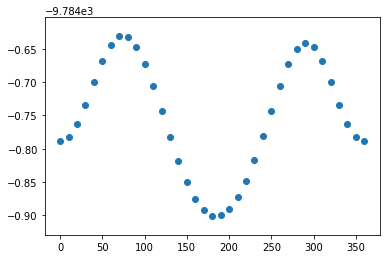

Continuous:   True
	Good Slope:   True

Lowest Conf:  False


<Torsion "(10, 1, 5, 4)">
NPWGWQRXHVJJRD-UHFFFAOYSA-N_tor15.log


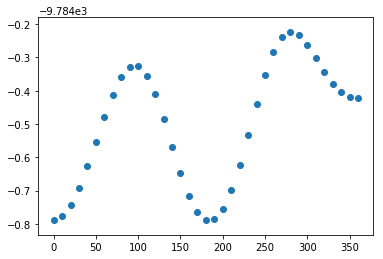

Continuous:   False
	Good Slope:   False

Lowest Conf:  True


<Torsion "(8, 3, 4, 6)">


common.py:266 check_conformer_energy WARNING the species corresponding to NPWGWQRXHVJJRD-UHFFFAOYSA-N_tor34.log is different in energy from the lowest energy conformer by 8.63 kJ/mol. This can cause significant errors in your computed rate constants. 


NPWGWQRXHVJJRD-UHFFFAOYSA-N_tor34.log


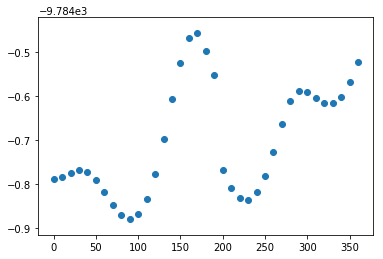

Continuous:   False
	Good Slope:   False

Lowest Conf:  False


<Torsion "(6, 4, 5, 2)">


common.py:266 check_conformer_energy WARNING the species corresponding to NPWGWQRXHVJJRD-UHFFFAOYSA-N_tor45.log is different in energy from the lowest energy conformer by 8.63 kJ/mol. This can cause significant errors in your computed rate constants. 


NPWGWQRXHVJJRD-UHFFFAOYSA-N_tor45.log


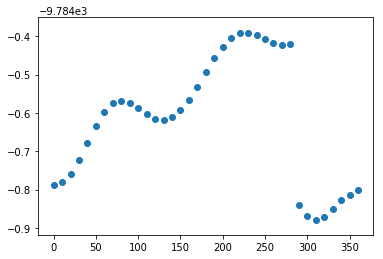

Continuous:   True
	Good Slope:   False

Lowest Conf:  False




In [3]:
from autotst.job import Job
auto_job = Job()

conf = Conformer('ONCC(=O)O')
steps = 36
step_size = 10.0

for torsion in conf.torsions:
    print torsion
    s = Scan(conf, torsion)
    s.set_DefaultFiles()
    s.set_Data()
    s.steps = steps
    s.stepsize_deg = step_size
    print s.output_log
    s.plot_Scan()
    print 'Continuous:  ', auto_job.check_rotor_continuous(steps, step_size, file_name=s.output_log)
    print '\tGood Slope:  ', auto_job.check_rotor_slope(steps, step_size, file_name=s.output_log)
    print '\nLowest Conf: ', auto_job.check_rotor_lowest_conf(file_name=s.output_log)[0]
    print '============================================================================================\n\n'

Steps:      36
Step Size:  -10.0

<Torsion "(9, 0, 3, 8)">


common.py:266 check_conformer_energy WARNING the species corresponding to NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by-10.0_tor03.log is different in energy from the lowest energy conformer by 10.82 kJ/mol. This can cause significant errors in your computed rate constants. 


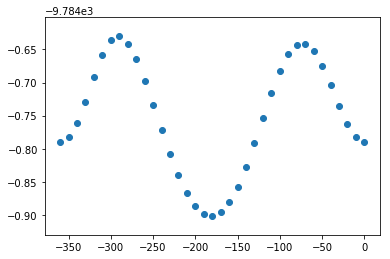

Continuous:   True
	Good Slope:   True

Lowest Conf:  False


<Torsion "(10, 1, 5, 4)">


common.py:266 check_conformer_energy WARNING the species corresponding to NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by-10.0_tor15.log is different in energy from the lowest energy conformer by 5.04 kJ/mol. This can cause significant errors in your computed rate constants. 


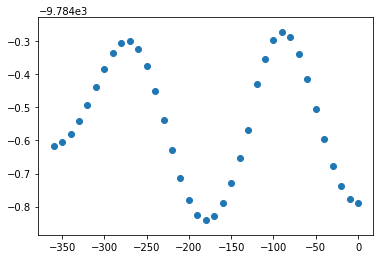

Continuous:   False
	Good Slope:   False

Lowest Conf:  False


<Torsion "(8, 3, 4, 5)">


common.py:266 check_conformer_energy WARNING the species corresponding to NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by-10.0_tor34.log is different in energy from the lowest energy conformer by 8.62 kJ/mol. This can cause significant errors in your computed rate constants. 


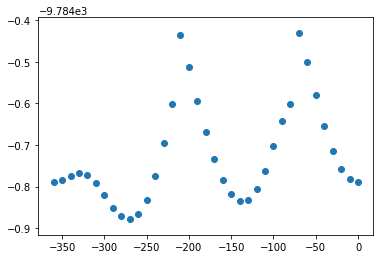

Continuous:   True
	Good Slope:   False

Lowest Conf:  False


<Torsion "(6, 4, 5, 2)">


common.py:266 check_conformer_energy WARNING the species corresponding to NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by-10.0_tor45.log is different in energy from the lowest energy conformer by 8.63 kJ/mol. This can cause significant errors in your computed rate constants. 


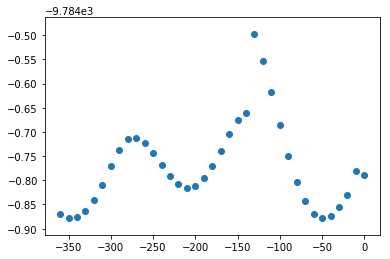

Continuous:   True
	Good Slope:   False

Lowest Conf:  False




In [9]:
from autotst.job import Job
auto_job = Job()

conf = Conformer('ONCC(=O)O')
steps = 36
step_size = -10.0
print 'Steps:     ', steps
print 'Step Size: ', step_size
print

for torsion in conf.torsions:
    print torsion
    s = Scan(conf, torsion)
    [i, j, k, l] = torsion.atom_indices
    s.output_log = conf.rmg_molecule.toAugmentedInChIKey() + '_{0}by{1}_tor{2}{3}.log'.format(steps, step_size, j,k)
    s.steps = steps
    s.stepsize_deg = step_size
    s.set_Data()
    s.plot_Scan()
    print 'Continuous:  ', auto_job.check_rotor_continuous(steps, step_size, file_name=s.output_log)
    print '\tGood Slope:  ', auto_job.check_rotor_slope(steps, step_size, file_name=s.output_log)
    print '\nLowest Conf: ', auto_job.check_rotor_lowest_conf(file_name=s.output_log)[0]
    print '============================================================================================\n\n'

Steps:      72
Step Size:  10.0

<Torsion "(9, 0, 3, 8)">


common.py:266 check_conformer_energy WARNING the species corresponding to NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by10.0_tor03.log is different in energy from the lowest energy conformer by 10.82 kJ/mol. This can cause significant errors in your computed rate constants. 


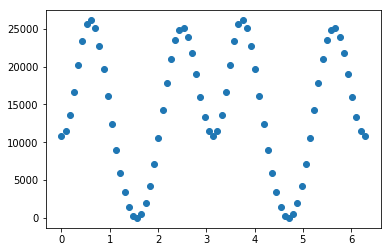

Continuous:   True
	Good Slope:   True

Lowest Conf:  False


<Torsion "(10, 1, 5, 4)">


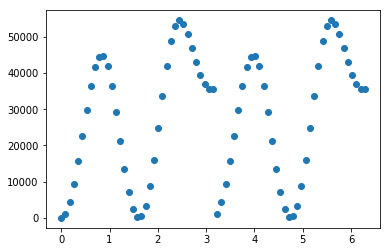

Continuous:   False
	Good Slope:   False

Lowest Conf:  True


<Torsion "(8, 3, 4, 6)">


common.py:266 check_conformer_energy WARNING the species corresponding to NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by10.0_tor34.log is different in energy from the lowest energy conformer by 14.22 kJ/mol. This can cause significant errors in your computed rate constants. 


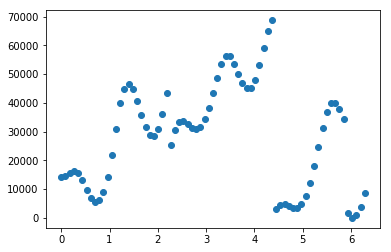

Continuous:   False
	Good Slope:   False

Lowest Conf:  False


<Torsion "(6, 4, 5, 2)">


common.py:266 check_conformer_energy WARNING the species corresponding to NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by10.0_tor45.log is different in energy from the lowest energy conformer by 17.65 kJ/mol. This can cause significant errors in your computed rate constants. 


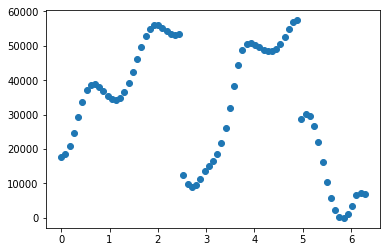

Continuous:   False
	Good Slope:   False

Lowest Conf:  False




In [17]:
from autotst.job import Job
auto_job = Job()

conf = Conformer('ONCC(=O)O')
steps = 72
step_size = 10.0
print 'Steps:     ', steps
print 'Step Size: ', step_size
print

for torsion in conf.torsions:
    print torsion
    s = Scan(conf, torsion)
    [i, j, k, l] = torsion.atom_indices
    s.output_log = conf.rmg_molecule.toAugmentedInChIKey() + '_{0}by{1}_tor{2}{3}.log'.format(steps, step_size, j,k)
    s.steps = steps
    s.stepsize_deg = step_size
    s.set_Data()
    s.plot_Scan()
    print 'Continuous:  ', auto_job.check_rotor_continuous(steps, step_size, file_name=s.output_log)
    print '\tGood Slope:  ', auto_job.check_rotor_slope(steps, step_size, file_name=s.output_log)
    print '\nLowest Conf: ', auto_job.check_rotor_lowest_conf(file_name=s.output_log)[0]
    print '============================================================================================\n\n'

Steps:      72
Step Size:  10.0
Attempt:    2

<Torsion "(9, 0, 3, 8)">


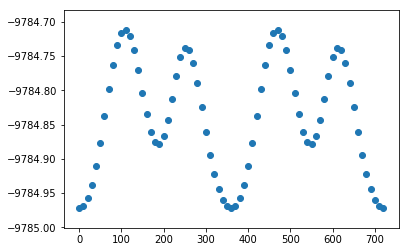

Continuous:   True
	Good Slope:   True

Lowest Conf:  True


<Torsion "(10, 1, 5, 4)">


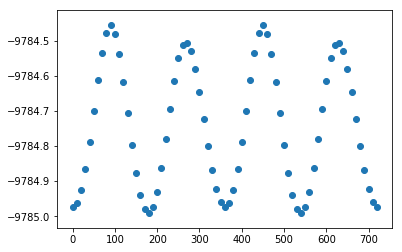

Continuous:   True
	Good Slope:   False

Lowest Conf:  False


<Torsion "(8, 3, 4, 6)">


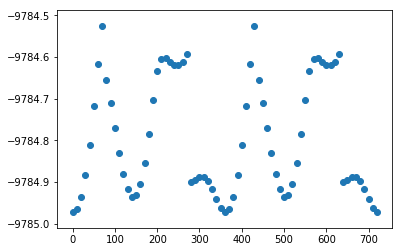

Continuous:   True
	Good Slope:   False

Lowest Conf:  True


<Torsion "(6, 4, 5, 2)">


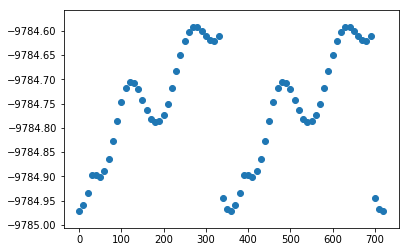

Continuous:   True
	Good Slope:   False

Lowest Conf:  True




In [10]:

from autotst.job import Job
auto_job = Job()

conf = Conformer('ONCC(=O)O')
steps = 72
step_size = 10.0
attempt = 2
print 'Steps:     ', steps
print 'Step Size: ', step_size
print 'Attempt:   ', attempt
print

for torsion in conf.torsions:
    print torsion
    s = Scan(conf, torsion)
    [i, j, k, l] = torsion.atom_indices
    s.output_log = conf.rmg_molecule.toAugmentedInChIKey() + '_{0}by{1}_tor{2}{3}_a{4}.log'.format(steps, step_size, j, k, attempt)
    s.steps = steps
    s.stepsize_deg = step_size
    s.set_Data()
    s.plot_Scan()
    print 'Continuous:  ', auto_job.check_rotor_continuous(steps, step_size, file_name=s.output_log)
    print '\tGood Slope:  ', auto_job.check_rotor_slope(steps, step_size, file_name=s.output_log)
    print '\nLowest Conf: ', auto_job.check_rotor_lowest_conf(file_name=s.output_log)[0]
    print '============================================================================================\n\n'

Steps:      72
Step Size:  10.0
Attempt:    1

<Torsion "(9, 0, 3, 8)">


common.py:266 check_conformer_energy WARNING the species corresponding to NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by10.0_tor03.log is different in energy from the lowest energy conformer by 15.81 kJ/mol. This can cause significant errors in your computed rate constants. 


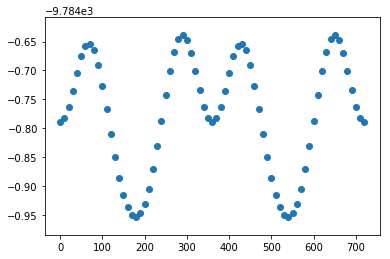

Continuous:   True
	Good Slope:   False

Lowest Conf:  False


<Torsion "(10, 1, 5, 4)">


common.py:266 check_conformer_energy WARNING the species corresponding to NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by10.0_tor15.log is different in energy from the lowest energy conformer by 4.80 kJ/mol. This can cause significant errors in your computed rate constants. 


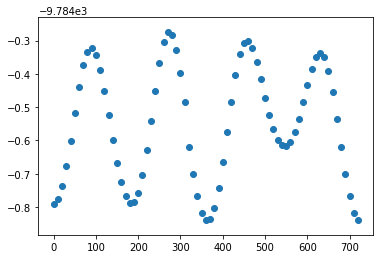

Continuous:   False
	Good Slope:   False

Lowest Conf:  False


<Torsion "(8, 3, 4, 7)">


common.py:266 check_conformer_energy WARNING the species corresponding to NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by10.0_tor34.log is different in energy from the lowest energy conformer by 24.36 kJ/mol. This can cause significant errors in your computed rate constants. 


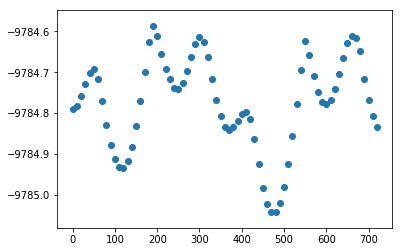

Continuous:   False
	Good Slope:   False

Lowest Conf:  False


<Torsion "(7, 4, 5, 2)">


common.py:266 check_conformer_energy WARNING the species corresponding to NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by10.0_tor45.log is different in energy from the lowest energy conformer by 4.96 kJ/mol. This can cause significant errors in your computed rate constants. 


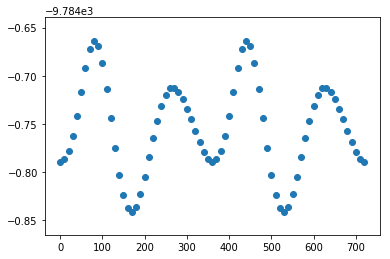

Continuous:   True
	Good Slope:   True

Lowest Conf:  False




In [10]:
home = '/home/underkoffler.c/Code/Hindered_Rotors/test_folder'
SMILES = 'ONCC(=O)O'
path = '/home/underkoffler.c/Code/Hindered_Rotors/{}/From_Workflow'.format(SMILES)
os.chdir(path)


from autotst.job import Job
auto_job = Job()

conf = Conformer(SMILES)
steps = 72
step_size = 10.0
attempt = 1
print 'Steps:     ', steps
print 'Step Size: ', step_size
print 'Attempt:   ', attempt
print

for torsion in conf.torsions:
    print torsion
    s = Scan(conf, torsion)
    [i, j, k, l] = torsion.atom_indices
    if attempt > 1:
        s.output_log = conf.rmg_molecule.toAugmentedInChIKey() + '_{0}by{1}_tor{2}{3}_a{4}.log'.format(steps, step_size, j, k, attempt)
    else:
        s.output_log = conf.rmg_molecule.toAugmentedInChIKey() + '_{0}by{1}_tor{2}{3}.log'.format(steps, step_size, j, k)
    
    s.steps = steps
    s.stepsize_deg = step_size
    s.set_Data()
    s.plot_Scan()
    print 'Continuous:  ', auto_job.check_rotor_continuous(steps, step_size, file_name=s.output_log)
    print '\tGood Slope:  ', auto_job.check_rotor_slope(steps, step_size, file_name=s.output_log)
    print '\nLowest Conf: ', auto_job.check_rotor_lowest_conf(file_name=s.output_log)[0]
    print '============================================================================================\n\n'

# Sample Iterative Workflow

General premise is that it will create inputs for Gaussian/Arkane and then execute them. Method will end at first execution, so user must re-run method after each calculation

In [5]:
from autotst.job import Reaction
rxn = Reaction('CCC(=O)OC+O[O]_C[CH]C(=O)OC+OO')

reaction.py:213 load_databases INFO Loading RMG database from '/home/underkoffler.c/Code/RMG-database/input'
thermo.py:840 loadLibraries INFO Loading thermodynamics library from primaryThermoLibrary.py in /home/underkoffler.c/Code/RMG-database/input/thermo/libraries...
thermo.py:840 loadLibraries INFO Loading thermodynamics library from thermo_DFT_CCSDTF12_BAC.py in /home/underkoffler.c/Code/RMG-database/input/thermo/libraries...
thermo.py:840 loadLibraries INFO Loading thermodynamics library from CBS_QB3_1dHR.py in /home/underkoffler.c/Code/RMG-database/input/thermo/libraries...
thermo.py:857 loadGroups INFO Loading thermodynamics group database from /home/underkoffler.c/Code/RMG-database/input/thermo/groups...
transport.py:294 loadGroups INFO Loading transport group database from /home/underkoffler.c/Code/RMG-database/input/transport/groups...
statmech.py:529 loadGroups INFO Loading frequencies group database from /home/underkoffler.c/Code/RMG-database/input/statmech/groups...
base.p

In [ ]:
assert False
Workflow(Conf_list = [], 
         SMILES_list = None, 
         Rxn_list = None, 
         modelChemistry = 'M06-2X/cc-pVTZ', 
         base_path = os.getcwd(), 
         given_steps = 36, 
         given_stpsize = 10.0, 
         log_name = None, 
         ThermoJob = False, 
         attempt = 0)

In [64]:
import os
import subprocess
import shlex

from ase.calculators.gaussian import Gaussian as ASE_Gaussian
from autotst.species import Conformer
from autotst.job import Job
auto_job = Job()

#Inputs
#SMILES_list = ['CC(CO)(C)OC']
#SMILES_list = ['CCCCCC(=O)O']
#SMILES_list = ['CC']
SMILES_list = ['ONCC(=O)O']
Conf_list = None
Rxn_list = None
modelChemistry = 'M06-2X/cc-pVTZ'
base_path = '/home/underkoffler.c/Code/Hindered_Rotors'
given_steps = 72
given_stpsize = 10.0
log_name = 'Rotors_{0}by{1}_Log'.format(given_steps, given_stpsize)
ThermoJob = True
attempt = 0

def Workflow(Conf_list=[], 
             SMILES_list=None,
             Rxn_list=None, 
             modelChemistry='M06-2X/cc-pVTZ', 
             base_path=os.getcwd(), 
             given_steps=36, 
             given_stpsize=10.0, 
             log_name=None, 
             ThermoJob=False, 
             attempt=1):
    """
    General premise:


    Iterate list of smiles, conf, or conf in reactions:
    If GeoFreq log does not exist or is incomplete:

        Writes GeoFreq Input if none found

        Executes GeoFreq Input
        Continues to next smiles in iteration

    Else:

        Updates geometry from GeoFreq log
        Generates scan object for every torsion

        Iterates through each scan object:

            If scan log does not exist or is incomplete:

                Writes scan input if none found

                Executes scan
                Continues to next scan in iteration

            Else:
                Updates scan with scan log

        If all scans have been updated from scan log:

            Writes species.py for SMILESif not found

            If specified as thermo calc:

                Writes thermo input for Arkane if none found
                Executes thermo input

                Adds arkane class instance to dictionary by smile


    """
    assert (SMILES_list is not None) or (Rxn_list is not None) or (len(Conf_list)!=0)

    if (SMILES_list is not None):
        Conf_list += [Conformer(SMILES) for SMILES in SMILES_list]

    if (Rxn_list is not None):
        for rxn in Rxn_list:
            for species in rxn.reactants:
                for reac_list in species.conformers.values():
                    Conf_list += reac_list

            for species in rxn.products:
                for prod_list in species.conformers.values():
                    Conf_list += prod_list
    
    if log_name is None:
        log_name = 'Rotors_{0}by{1}_a{2}_Log'.format(given_steps, given_stpsize, attempt)
    log = []
    
    assert attempt > 0
    
    ark_dict = {}
    for SMILES in SMILES_list:
        path = '{0}/{1}/From_Workflow'.format(base_path, SMILES)
        if not os.path.isdir(path):
            os.mkdir(path)

        os.chdir(path)
        print os.getcwd()
        
        if not os.path.isfile('rotors_run_script'):
            generate_rotors_run_script(path=path)
        
        log += ['\n\n===========================================================================================']
        log += ['Beginning workflow for {0} at:\n\t{1}'.format(SMILES, path)]
        
        conf = Conformer(SMILES)
        augInChI = conf.rmg_molecule.toAugmentedInChIKey()

        geoFreqBase = augInChI + '_GeoFreq_a{}'.format(attempt)
        geoFreqCom = geoFreqBase + '.com'
        geoFreqLog = geoFreqBase + '.log'

        hind = Hindered_Rotors(conf)

        gaus_job = ASE_Gaussian()

        geoFreqCom_Path = os.path.join(path, geoFreqCom)
        geoFreqLog_Path = os.path.join(path, geoFreqLog)

        if not exists_and_complete(geoFreqLog_Path):
            log += ['Geometry & Frequency log file NOT FOUND or NOT COMPLETE\n\t{0} for {1} NOT FOUND or NOT COMPLETE.\n\tLooking for {0}'.format(geoFreqCom, SMILES)]
            if not os.path.isfile(geoFreqCom_Path):
                conf = lowest_conf(SMILES)
                write_GeoFreq(conf, geoFreqBase, path=path)
                log += ['Geometry & Frequencey input file NOT FOUND\n\t{0} for {1} NOT FOUND.\n\tGenerating one now...'.format(geoFreqCom, SMILES)]
            else:
                log += ['Using previous geometry & frequency input file']

            assert os.path.isfile(geoFreqCom_Path)
            #os.chdir(path)
            log += ['EXECUTING {0}'.format(geoFreqCom)]
            subprocess.call(shlex.split('sbatch rotors_run_template.sh {0}'.format(geoFreqBase)))
            #os.chdir(home)

        else:
            log += ['Geometry & Frequency log file is complete!\n\t{0} for {1} is complete!'.format(geoFreqLog, SMILES)]
            assert hind.update_Conformer(filename=geoFreqLog, path=path)
            hind.generate_Scans(path=path)

            all_Scans_Updated = True
            for scan in hind.scans:
                (i, j, k, l) = scan.get_Torsion().atom_indices

                scan.geo_log = geoFreqLog
                
                scan.input_com = augInChI + '_{0}by{1}_tor{2}{3}_a{4}.com'.format(given_steps, given_stpsize, j, k, attempt)
                scan.output_log = augInChI + '_{0}by{1}_tor{2}{3}_a{4}.log'.format(given_steps, given_stpsize, j, k, attempt)

                log += ['Looking at {} torsion in {}'.format((i,j,k,l), SMILES)]

                verify_info = {}
                if exists_and_complete(os.path.join(scan.path, scan.output_log)):
                    scan.set_Data()
                    log += ['\tTorsion log file is complete!\n\t\t{0} for {1} exists and is complete!'.format(scan.output_log, SMILES)]
                    scan_info = auto_job.verify_rotor(given_steps, given_stpsize, file_name=scan.output_log)
                    [verified, energy, atomnos, atomcoords] = scan_info
                    if not verified:
                        all_Scans_Updated = False
                        log += ['{} NOT Verified. Suggest running with different initial geometry'.format(scan.get_Torsion().atom_indices)]
                    else:
                        log += ['{} Verified!'.format(scan.get_Torsion().atom_indices)]
                else:
                    all_Scans_Updated = False
                    log += ['\tTorsion log file NOT FOUND or NOT COMPLETE.\n\t\t{0} for {1} NOT FOUND or NOT COMPLETE.\n\t\tLooking for existing {2}'.format(scan.output_log, SMILES, scan.input_com)]
                    if not os.path.isfile(os.path.join(path, scan.input_com)):
                        log += ['\tTorsion input file NOT FOUND.\n\t\t{0} for {1} NOT FOUND.\n\t\tGenerating one now..'.format(scan.input_com, SMILES)]
                        scan.write_TorInput(steps=given_steps, stepsize_deg=given_stpsize)
                    else:
                        log += ['\tUsing previous torsion input file.\n\t\t{0} for {1} exists!'.format(scan.input_com, SMILES)]

                    #os.chdir(path)

                    log += ['\tEXECUTING {0}'.format(scan.input_com)]
                    tor_base = scan.input_com.strip('.com')

                    subprocess.call(shlex.split('sbatch rotors_run_template.sh {0}'.format(tor_base)))
            
            
            if allScansUpdated:

                log += ['All scans for {0} have data!'.format(SMILES)]
                statmech_job = fake_statmech()
                statmech_job.model_chemistry = modelChemistry

                species_py = augInChI + '.py'
                if not os.path.isfile(os.path.join(path, species_py)):
                    log += ['Arkane Species.py file NOT FOUND\n\t{0} NOT FOUND for {1}\n\tGenerating one now...'.format(species_py, SMILES)]

                    torsions = hind.get_Torsions()

                    statmech_job.write_arkane_for_reacts_and_prods(conf, label=augInChI)
                else:
                    log += ['Species.py for {0} exists!\n\t{1}'.format(SMILES, species_py)]

                assert os.path.isfile(species_py)

                if ThermoJob:
                    spec_file = species_py
                    log += ['Beginning Thermo Calculations']
                    thermo_filename = augInChI + '_Thermo.py'
                    out_path = os.getcwd()
                    spec_name = augInChI
                    if not os.path.isfile(os.path.join(path, thermo_filename)):
                        log += ['Thermo input file NOT FOUND\n\t{0} NOT FOUND for {1}\t\nGenerating one now...'.format(thermo_filename, SMILES)]

                        write_ArkaneThermoInput(thermo_filename, modelChemistry, spec_name, spec_file)

                    log += ['Executing Arkane Thermo Job for {0}\n\tAKA {1}'.format(species_py, SMILES)]
                    log += ['Arkane log named "arkane.log"\n\tat {0}'.format(path)]

                    ark = arkane.Arkane(inputFile=thermo_filename, outputDirectory=out_path)
                    ark.plot = False
                    ark.execute()
                    ark_dict[SMILE] = ark
        log += ['\n\n===========================================================================================']

        output = '\n\n'.join(log)
        with open(os.path.join(path, log_name), 'w') as f:
            f.write(output)

    return

In [48]:
Rxn_list = None
Workflow(Conf_list=[], 
         SMILES_list=None, 
         Rxn_list=Rxn_list, 
         modelChemistry='M06-2X/cc-pVTZ', 
         base_path='/home/underkoffler.c/Code/Hindered_Rotors', 
         given_steps=72, 
         given_stpsize=10.0, 
         log_name=None, 
         ThermoJob=False, 
         attempt=1)

AssertionError: 

In [72]:
"""rxn_SMILES_list = [
    'CCCCO+[OH]_CCCC[O]+O',
    'CCOC+[OH]_C[CH]OC+O',
    'COC(C)C+[OH]_CO[C](C)C+O',
    'CCC(=O)OC+[CH3]_C[CH]C(=O)OC+C',
    
]
"""
SMILES_list = [
    'CCCCO', 
    'CCOC',
    'COC(C)C',
    'CCC(=O)OC' 
]

assert False
Workflow(Conf_list=[], 
         SMILES_list=SMILES_list, 
         Rxn_list=Rxn_list, 
         modelChemistry='M06-2X/cc-pVTZ', 
         base_path='/home/underkoffler.c/Code/Hindered_Rotors', 
         given_steps=72, 
         given_stpsize=10.0, 
         log_name=None, 
         ThermoJob=False, 
         attempt=1)

/home/underkoffler.c/Code/Hindered_Rotors/CCCCO/From_Workflow
/home/underkoffler.c/Code/Hindered_Rotors/CCOC/From_Workflow
/home/underkoffler.c/Code/Hindered_Rotors/COC(C)C/From_Workflow
/home/underkoffler.c/Code/Hindered_Rotors/CCC(=O)OC/From_Workflow


AssertionError: 

In [29]:
from autotst.job import Job
auto_job = Job()

SMILES = 'ONCC(=O)O'


conf = Conformer(SMILES)
path = '/home/underkoffler.c/Code/Hindered_Rotors/{}/From_Workflow'.format(SMILES)

os.chdir(path)

augInChI = conf.rmg_molecule.toAugmentedInChIKey()

(i, j, k, l) = conf.torsions[0].atom_indices

steps = 72
step_size = 10.0
tor_base = '{0}_{1}by{2}_tor{3}{4}'.format(augInChI, steps, step_size, j, k)

prev_attempt = 10
file_name = tor_base + '_a{}.log'.format(prev_attempt)


while not os.path.isfile(file_name):
    prev_attempt -= 1
    assert attempt != 0
    file_name = tor_base + '_a{}.log'.format(prev_attempt)
print 'Previous Attempt: ', prev_attempt

Previous Attempt:  2


In [30]:
from rmgpy.molecule import Molecule as RMG_Molecule

def get_updated_mol_ingredients(conf, steps, step_size, current_attempt):
    
    SMILES = conf.smiles
    net_charge = conf.rmg_molecule.getNetCharge()
    
    min_atomnos = None
    min_atomcoords = None
    min_energy = None
    all_verified = True

    for torsion in conf.torsions:
        (i, j, k, l) = torsion.atom_indices

        output_log = '{0}_{1}by{2}_tor{3}{4}_a{5}.log'.format(augInChI, steps, step_size, j, k, attempt)
        assert exists_and_complete(output_log), 'Run currently in progress or DNF. Maybe rerun to completion or delete'

        scan_info = auto_job.verify_rotor(steps, step_size, file_name=output_log)
        [verified, energy, atomnos, atomcoords] = scan_info
        if not verified:
            all_verified = False
            if min_energy is None:
                min_energy = energy
                min_atomnos = atomnos
                min_atomcoords = atomcoords
            elif energy<min_energy:
                min_energy = energy
                min_atomnos = atomnos
                min_atomcoords = atomcoords

    assert min_atomnos is not None
    assert min_atomcoords is not None
    
    return SMILES, min_atomnos, min_atomcoords, net_charge


In [40]:

import subprocess
import shlex

conf.rmg_molecule = updated_mol
steps = 1000
step_size = 10.0

for torsion in conf.get_torsions():
    assert False
    (i, j, k, l) = torsion.atom_indices
    s = Scan(conf, torsion)
    assert exists_and_complete('{}_{}by{}_tor{}{}_a{}.log'.format(augInChIKey, steps, step_size, j, k, attempt-1)), '{}_{}by{}_tor{}{}_a{}.log'.format(augInChI, steps, step_size, j, k, attempt-1)
    assert not os.path.isfile('{}_{}by{}_tor{}{}_a{}.log'.format(augInChIKey, steps, step_size, j, k, attempt-1)), '{}_{}by{}_tor{}{}_a{}.log'.format(augInChI, steps, step_size, j, k, attempt)
    s.input_com = '{}_{}by{}_tor{}{}_a{}.com'.format(augInChIKey, steps, step_size, j, k, attempt)
    s.steps = steps
    s.stepsize_deg = step_size
    s.path = os.getcwd()
    s.write_TorInput()
    new_tor_base = s.input_com.strip('.com')
    print new_tor_base
    subprocess.call(shlex.split('sbatch rotors_run_template.sh {0}'.format(new_tor_base)))

AssertionError: 

In [41]:
conf = Conformer('ONCC(=O)O')

file_name = 'NPWGWQRXHVJJRD-UHFFFAOYSA-N_tor45.log'
print file_name, '\n'
parser = cclib.io.ccread(file_name)

opt_indices = [i for i, status in enumerate(parser.optstatus) if status==2]
start_indices = [i for i, status in enumerate(parser.optstatus) if status==1]
opt_SCFEnergies = [parser.scfenergies[index] for index in opt_indices]

print opt_indices
print

for i, opt_index in enumerate(opt_indices):
    print 'Opt Geo:   ', i
    print 'Opt Index: ', opt_index
    print 'Energy:    ', parser.scfenergies[opt_index]
    geo = parser.atomcoords.tolist()[opt_index]
    for atomno, coords in zip(atomnos, geo):
        print atomno, '\t', coords

        
atomnos = parser.atomnos.tolist()
atomcoords = parser.atomcoords.tolist()[min_opt_idx]

NPWGWQRXHVJJRD-UHFFFAOYSA-N_tor45.log 

[0, 4, 8, 11, 16, 20, 24, 29, 34, 38, 42, 46, 50, 54, 57, 61, 65, 69, 74, 78, 82, 86, 90, 93, 97, 100, 103, 107, 112, 130, 135, 139, 143, 148, 154, 160, 165]

Opt Geo:    0
Opt Index:  0
Energy:     -9784.7890634
8 	[2.489568, 0.001589, -0.207874]
8 	[-1.227273, 1.247054, -0.106967]
8 	[-2.157277, -0.761642, 0.071281]
7 	[1.218653, 0.303079, 0.306409]
6 	[0.223907, -0.674639, -0.104244]
6 	[-1.180649, -0.083826, -0.023208]
1 	[0.410958, -0.895677, -1.156277]
1 	[0.235423, -1.614175, 0.453244]
1 	[1.29909, 0.341365, 1.318231]
1 	[2.739852, -0.87688, 0.10574]
1 	[-0.315579, 1.578597, -0.152599]

Opt Geo:    1
Opt Index:  4
Energy:     -9784.78116042
8 	[2.496934, 0.017841, -0.156392]
8 	[-1.248176, 1.242066, -0.114034]
8 	[-2.135628, -0.777989, 0.132409]
7 	[1.207363, 0.28734, 0.328261]
6 	[0.231062, -0.651623, -0.201591]
6 	[-1.176746, -0.089379, -0.035459]
1 	[0.426005, -0.717095, -1.273648]
1 	[0.26167, -1.654026, 0.231091]
1 	[1.245424, 0.24335

Opt Geo:    25
Opt Index:  100
Energy:     -9784.40743374
8 	[2.533379, -0.069366, -0.069196]
8 	[-1.624905, 1.118216, -0.083207]
8 	[-1.782115, -1.081784, -0.2022]
7 	[1.204114, -0.053253, -0.518643]
6 	[0.296629, -0.200647, 0.607475]
6 	[-1.132879, -0.131013, 0.088181]
1 	[0.450844, -1.179423, 1.052653]
1 	[0.458134, 0.563712, 1.385851]
1 	[1.05362, 0.827151, -1.00333]
1 	[2.643507, 0.631674, 0.587704]
1 	[-1.028281, 1.783086, 0.270509]

Opt Geo:    26
Opt Index:  103
Energy:     -9784.4170707
8 	[2.531725, -0.087131, -0.07808]
8 	[-1.546197, 1.155656, -0.018681]
8 	[-1.865054, -1.01882, -0.238045]
7 	[1.204433, 0.034525, -0.516486]
6 	[0.290327, -0.324964, 0.556053]
6 	[-1.139053, -0.132289, 0.073627]
1 	[0.428694, -1.375531, 0.793205]
1 	[0.456738, 0.264734, 1.473133]
1 	[1.067983, 0.994042, -0.821391]
1 	[2.64584, 0.462059, 0.709679]
1 	[-0.901717, 1.758894, 0.361141]

Opt Geo:    27
Opt Index:  107
Energy:     -9784.42165373
8 	[2.534307, -0.103815, -0.080638]
8 	[-1.492891, 1.17

# Things I just don't want to delete:

In [ ]:
"""#Inputs to write thermo
SML = 'CC(CO)(C)OC'
conf = Conformer(SML)
label = conf.rmg_molecule.toAugmentedInChIKey()
spec_file = label + '.py'

thermo_filename = 'thermo_input.py'

modelChemistry = 'M06-2X/cc-pVTZ'

spec_name = 'my_species'


#Inputs to execute Arkane
out_path = os.getcwd()


write_ArkaneThermoInput(thermo_filename, modelChemistry, spec_name, spec_file)
ark = arkane.Arkane(inputFile=thermo_filename, outputDirectory=out_path)


ark.plot = False
#ark.execute()"""
x=1

In [ ]:
"""
        #Keeping atomcoords organized with their respective atom nos for easy ID
        atom_id_coords = []
        atomids = self.data.atomnos
        for i, geo_coords in enumerate(self.data.atomcoords):
            #Setting up [atomno, x, y, x] for each atom in a geometry
            geo_id_coords = np.insert(geo_coords, 0, atomids, axis=1)
            #Adding all of individual geometries to master list
            atom_id_coords.append(geo_id_coords)
        
        self.atomcoords = atom_id_coords"""
x=1

In [42]:
# To create new template run-script

#rotors_runscript_template = "#!/bin/bash\n\n#SBATCH --job-name=$1\n#SBATCH --output=$1.log\n\n## number of nodes\n#SBATCH -N 1\n#SBATCH --exclusive\n#SBATCH --partition=general\n#SBATCH --mem=120000\n\n## set the gaussian scratch directory to a fast drive\n## note that /tmp/ may be even faster than /gss_gpfs_scratch/\n#export GAUSS_SCRDIR=/scratch/$USER/gaussian_scratch\n## make the directory if it doesn't exist already\n#mkdir -p $GAUSS_SCRDIR\n\n# run gaussian, with the desired input file\ng16 $1.com\n\n"
path = '/home/underkoffler.c/Code/Hindered_Rotors/{}/From_Workflow'.format(SMILES)

def generate_rotors_run_script(path=os.getcwd()):
    
    lst_template = ["#!/bin/bash",
                    "",
                    "#SBATCH --job-name=AutoScript",
                    "#SBATCH --output=$1.log",
                    "",
                    "## number of nodes",
                    "#SBATCH -N 1",
                    "#SBATCH --exclusive",
                    "#SBATCH --partition=general",
                    "#SBATCH --mem=120000",
                    "",
                    "## export GAUSS_SCRDIR=/scratch/$USER/gaussian_scratch",
                    "## make the directory if it doesn't exist already",
                    "## mkdir -p $GAUSS_SCRDIR",
                    "",
                    "## run gaussian, with the desired input file",
                    "g16 $1.com",
                    "",
                    ""]

    #new_script_template = open('rotors_run_template.sh', 'w')
    #new_script_template.write('\n'.join(lst_template))
    template ='\n'.join(lst_template)
    with open('{}/rotors_run_template.sh'.format(path), 'w') as f:
        f.write(template)
#new_script_template.close()
#print rotors_runscript_template


/home/underkoffler.c/Code/Hindered_Rotors/ONCC(=O)O/From_Workflow
#!/bin/bash

#SBATCH --job-name=AutoScript
#SBATCH --output=$1.log

## number of nodes
#SBATCH -N 1
#SBATCH --exclusive
#SBATCH --partition=general
#SBATCH --mem=120000

## export GAUSS_SCRDIR=/scratch/$USER/gaussian_scratch
## make the directory if it doesn't exist already
## mkdir -p $GAUSS_SCRDIR

## run gaussian, with the desired input file
g16 $1.com




In [30]:
"""
#!/bin/bash

#SBATCH --job-name={}
#SBATCH --output={}.log

## number of nodes
#SBATCH -N 1
#SBATCH --exclusive
#SBATCH --partition=general
#SBATCH --mem=120000

## set the gaussian scratch directory to a fast drive
## note that /tmp/ may be even faster than /gss_gpfs_scratch/
#export GAUSS_SCRDIR=/gss_gpfs_scratch/$USER/gaussian_scratch
## make the directory if it doesn't exist already
#mkdir -p $GAUSS_SCRDIR

# run gaussian, with the desired input file
g16 {}.com
"""
x=1

In [ ]:
"""x = RMG_Molecule()
SML = 'CC(CO)(C)OC'
x.fromSMILES(SML)
piv_bond = None
i = 1
for atom in x.atoms:
    atom.id = i
    i+=1

for bond in x.getAllEdges():
    print bond.atom1.id, bond.atom2.id
    if (bond.atom1.id == 2 and bond.atom2.id == 4) or (bond.atom1.id == 2 and bond.atom2.id == 4):
        piv_bond = bond
print "Piv Bond: ", piv_bond"""
x=1

In [ ]:
"""from autotst.calculators.gaussian import read_gaussian_out
geo_log = "VMPUAIZSESMILD-UHFFFAOYSA-N_Geo.log"
conf.ase_molecule = read_gaussian_out(geo_log)
conf.update_coords()"""
x=1

In [ ]:
#subprocess.call(shlex.split('sbatch rotors_run_template.sh {0}'.format(name_base)))

In [ ]:
    
"""    def write_Geo_Input(self):
        # Preparing gaussian input file for Geo Opt
        gaus_job = Gaussian()
        gaus_job.label = self.label + '_Geo'
        gaus_job.parameters['method'] = 'm062x'
        gaus_job.parameters['basis'] = '6-311+g(2df,2p)'
        gaus_job.extra = 'opt=(calcfc,maxcycle=1000)'
        del gaus_job.parameters['force']

        # Write geo input file
        gaus_job.write_input(.ase_molecule)"""
"""    
    def write_Freq_Input(self, freq_file=None,  path=None, options=None):
        # Preparing gaussian input file for Freq Calc
        if self.geoIsOpt:
            mol = self.getRMGMol()
            mol.updateMultiplicity()
            
            if freq_file is None:
                freq_file = self.label + '_Freq.com'
                
            if path is None:
                path = self.path
            
            if options is None:
                options = ['%nprocshared=20',
                           '%mem=5GB',
                           '#p m062x/6-311+g(2df,2p) freq iop(7/33=1)']

            output = '\n'.join(options)
            
            output += '\n'.join(['','','0 {}'.format(mol.multiplicity),''])

            n = 1
            for atom in mol.atoms:
                assert n == atom.id
                n += 1
                output += "{}     {}     {}     {}\n".format(atom.element, atom.coords[0], atom.coords[1], atom.coords[2])
            
            with open(os.path.join(path, freq_file), 'w') as f:
                f.write(output)
                f.close()
            return
    
    def getRMGMol(self):
        return self.__RMGMol__
"""            
"""
    def updateMol(self, geo_file=None, path=None):
        assert self.__RMGMol__ is None, "Highly recommended not to update molecule more than once"
        
        if geo_file is None:
            geo_file = self.label + '_Geo.log'
        if path is None:
            path = self.path
        
        atoms = None
        try:
            atoms = read_gaussian_out(geo_file)
        except:
            print "Failed to Find Valid Geo_file"
            return False
        
        #Update XYZ
        mol = RMG_Molecule()
        mol.fromXYZ(atoms.get_atomic_numbers(), atoms.get_positions())
        
        #Update IDs
        i = 1
        for atom in mol.atoms:
            atom.id = i
            i += 1
        
        #Update Multiplicity
        mol.updateMultiplicity()
        
        self.__RMGMol__ = mol
        self.geoIsOpt = True
        return True
    
    
            
    def set_torsions(self):
        Method setting torsions of simple chains to hindered rotors object

        NO RINGS
        NO RINGS
        NO RINGS

        A - Bond1 - B - Bond2 - C - Bond3 - D

        i = A.index
        j = B.index
        k = C.index
        l = D.index

        Torsion is unique if j,k & k,j pairing is unique

        """
"""
        if not self.geoIsOpt:
            self.updateMol()
        
        assert self.geoIsOpt
        mol = self.getRMGMol()
 
        # dict of (j, k) key with [i,j,k,l] value
        # Wipes existing torsions away to recalculate
        self.torsions = {}
            
        for bond2 in mol.getAllEdges():
            i, j, k, l = -1,-1,-1,-1
            B = bond2.atom1
            j = bond2.atom1.id

            C = bond2.atom2
            k = bond2.atom2.id

            assert (j,k) not in self.torsions.keys() or (k,j) in torsions.keys()
            # [i,j,k,l] and [i,j,k,m] torsion is the same to Gaussian as long as center is k&j or j&k
            #continue

            found_bond1 = False
            found_bond3 = False

            for Bbond in mol.getBonds(B).values():
                if (Bbond.atom1.id == B.id) and (Bbond.atom2.id != C.id):
                    #Bbond is not bond2
                    #Bbond must be bond1
                    found_bond1 = True
                    i = Bbond.atom2.id
                elif (Bbond.atom1.id != C.id) and (Bbond.atom2.id == B.id):
                    #Bbond is not bond2
                    #Bbond must be bond1
                    found_bond1 = True
                    i = Bbond.atom1.id
                else:
                    #Bbond is bond2
                    assert (Bbond.atom1 == C) or (Bbond.atom2 == C)

            for Cbond in mol.getBonds(C).values():
                if (Cbond.atom1.id == C.id) and (Cbond.atom2.id != B.id):
                    #Bbond is not bond2
                    #Bbond must be bond3
                    found_bond3 = True
                    l = Cbond.atom2.id
                elif (Cbond.atom1.id != B.id) and (Cbond.atom2.id == C.id):
                    #Bbond is not bond2
                    #Bbond must be bond1
                    found_bond3 = True
                    l = Cbond.atom1.id
                else:
                    #Cbond is bond2
                    assert (Cbond.atom1 == B) or (Cbond.atom2 == B)

            #print found_bond1, found_bond3
            #print i, j, k, l
            #print
            if found_bond1 and found_bond3:
                self.torsions[(j,k)] = [i,j,k,l]
        return
"""   
"""
    def Rote_write_geo_com(self, filename=None):
        
        #Writes Gaussian input file for a geometry optimization of self.__RMGMol__
        #with a basisand parameters similar to AutoTST
        
        auto_mol = None
        if filename is None:
            filename = self.AugInchiKey + '_Geo.com'

        # Preparing gaussian input file parameters for Geo Opt as AutoTST does it
        g_inst = Gaussian()
        g_inst.label = self.AugInchiKey + '_Geo'
        
        g_inst.parameters['method'] = 'm062x'
        g_inst.parameters['basis'] = '6-311+g(2df,2p)'
        g_inst.extra = 'opt=(calcfc,maxcycle=1000)'
        del g_inst.parameters['force']

        # Write Gaussian input file
        # TODO Fix
        test_g.write_input(auto_mol.ase_molecule)
        return False
    """
x=1